In [1]:
# ============================================
# 0. Setup: imports, options, helper functions
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Nice plotting defaults
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

pd.set_option("display.float_format", lambda x: f"{x:,.3f}")


# ---------- Helper: ADF test ----------
def adf_test(series, name="", alpha=0.05):
    """Run Augmented Dickey-Fuller test and print result."""
    s = series.dropna().astype(float)
    result = adfuller(s)
    pval = result[1]
    print(f"{name}: ADF p-value = {pval:.4f}")
    if pval < alpha:
        print("  → Stationary ✅\n")
    else:
        print("  → Non-stationary ⚠️\n")
    return pval


# ---------- Helper: simple differencing ----------
def diff_series(series, name=""):
    """Return first difference with a cleaner name."""
    s_diff = series.diff().dropna()
    s_diff.name = f"{name}_diff" if name else series.name + "_diff"
    return s_diff


# ---------- Helper: model evaluation ----------
def evaluate_forecast(y_true, y_pred, label="Model"):
    """Compute RMSE and MAE."""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{label} – RMSE: {rmse:.3f}, MAE: {mae:.3f}")
    return rmse, mae


# ---------- Helper: residual diagnostics ----------
def residual_diagnostics(residuals, lags=12, title_prefix=""):
    """Quick residual check: ACF, histogram, Ljung-Box."""
    res = residuals.dropna()

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # 1) Histogram
    axes[0].hist(res, bins=20, edgecolor="black")
    axes[0].set_title(f"{title_prefix} Residuals Histogram")
    
    # 2) ACF
    plot_acf(res, lags=lags, ax=axes[1])
    axes[1].set_title(f"{title_prefix} Residuals ACF")
    
    # 3) Ljung-Box
    lb = acorr_ljungbox(res, lags=[lags], return_df=True)
    lb_p = lb["lb_pvalue"].iloc[0]
    axes[2].axis("off")
    axes[2].text(
        0.1, 0.6,
        f"Ljung-Box (lag {lags}) p-value = {lb_p:.3f}\n"
        + ("→ Looks uncorrelated ✅" if lb_p > 0.05 else "→ Autocorrelation remains ⚠️"),
        fontsize=12,
    )
    plt.tight_layout()
    plt.show()
    return lb_p

print("✅ Setup done. Ready to load data.")

✅ Setup done. Ready to load data.


In [3]:
# ============================================
# 1. Load datasets and inspect basic structure
# ============================================

# 1) Military compensation
comp = pd.read_csv("Military_Compensation.csv", parse_dates=["date"])
comp.set_index("date", inplace=True)
comp = comp.sort_index()
comp.drop()
print("=== Military Compensation ===")
print(comp.head())
print("Shape:", comp.shape)
print("Date range:", comp.index.min().date(), "→", comp.index.max().date())
print()

# 2) Economic factors (already transformed & ready)
eco = pd.read_csv("economical_ready_for_modeling.csv", parse_dates=["date"])
eco.set_index("date", inplace=True)
eco = eco.sort_index()

print("=== Economic Factors (ready) ===")
print(eco.head())
print("Columns:", list(eco.columns))
print("Shape:", eco.shape)
print("Date range:", eco.index.min().date(), "→", eco.index.max().date())
print()

# 3) Geopolitical factors (already transformed & ready)
geo = pd.read_csv("geopolitical_ready_for_modeling.csv", parse_dates=["date"])
geo.set_index("date", inplace=True)
geo = geo.sort_index()

print("=== Geopolitical Factors (ready) ===")
print(geo.head())
print("Columns:", list(geo.columns))
print("Shape:", geo.shape)
print("Date range:", geo.index.min().date(), "→", geo.index.max().date())
print()

# Quick null check
print("Missing values:")
print("comp:", comp.isna().sum().sum())
print("eco :", eco.isna().sum())
print("geo :", geo.isna().sum())

=== Military Compensation ===
            military_comp
date                     
1993-03-31         76.610
1993-06-30         75.756
1993-09-30         74.416
1993-12-31         73.552
1994-03-31         73.021
Shape: (130, 1)
Date range: 1993-03-31 → 2025-06-30

=== Economic Factors (ready) ===
            military_comp  gdp_growth  eci_growth_diff  inflation_rate_diff
date                                                                       
1993-06-30         75.756       0.582           -0.629               -0.048
1993-09-30         74.416       0.477            0.454               -0.308
1993-12-31         73.552       1.360           -0.464               -0.048
1994-03-31         73.021       0.970            0.296               -0.230
1994-06-30         71.829       1.355           -0.157               -0.157
Columns: ['military_comp', 'gdp_growth', 'eci_growth_diff', 'inflation_rate_diff']
Shape: (129, 4)
Date range: 1993-06-30 → 2025-06-30

=== Geopolitical Factors (ready) =

# Autocorrelation and Partial Autocorrelation Analysis

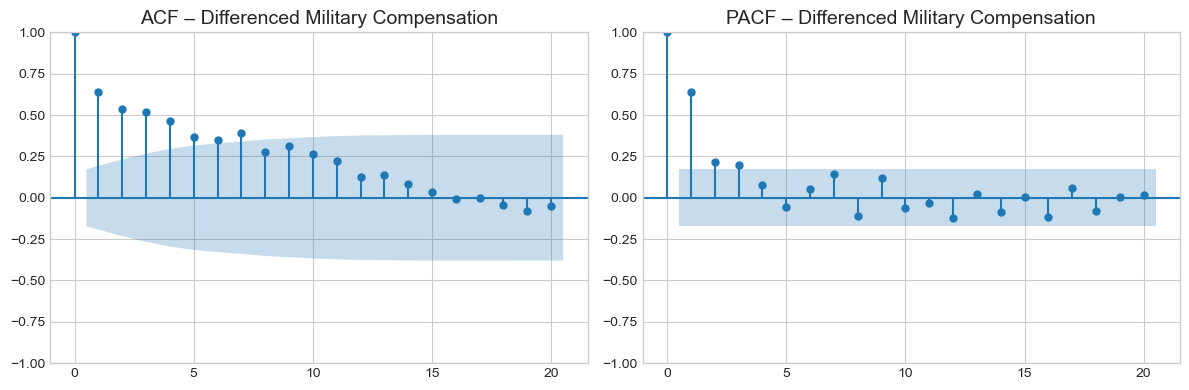

In [94]:
# ============================================
# 2a. ACF and PACF analysis for order selection
# ============================================

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# --- If military_comp is non-stationary, difference it ---
y_diff = comp["military_comp"].diff().dropna()

# --- Plot ACF and PACF ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(y_diff, lags=20, ax=axes[0])
axes[0].set_title("ACF – Differenced Military Compensation")

plot_pacf(y_diff, lags=20, ax=axes[1])
axes[1].set_title("PACF – Differenced Military Compensation")

plt.tight_layout()
plt.show()

In [95]:
# First differencing the military compensation series
military_comp_diff = comp.diff().dropna()

# Run ADF test on the differenced military compensation series
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(military_comp_diff)

# Print the result
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print(f"Critical Values: {adf_result[4]}")

ADF Statistic: -2.991520992022424
p-value: 0.035693855954903264
Critical Values: {'1%': np.float64(-3.4833462346078936), '5%': np.float64(-2.8847655969877666), '10%': np.float64(-2.5791564575459813)}


# Choosing parameters for Arima model
- The AR term (p) should be 1 (because PACF cuts off at lag 1)
- The MA term (q) should be 0 or 1 (because the ACF tapers slowly, consistent with a low-order MA effect)
- After differencing once, since the ADF statistic is very negative(-3.57) and the p-value is small(0.006), we can conclude that the series does not need further differencing. It is already stationary after the first differencing.

# First model: ARIMA(1,1,1)

/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:          military_comp   No. Observations:                  130
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -211.747
Date:                Sat, 15 Nov 2025   AIC                            429.493
Time:                        16:26:41   BIC                            438.073
Sample:                    03-31-1993   HQIC                           432.979
                         - 06-30-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9482      0.026     36.490      0.000       0.897       0.999
ma.L1         -0.5490      0.078     -7.031      0.000      -0.702      -0.396
sigma2         1.5463      0.125     12.350      0.0

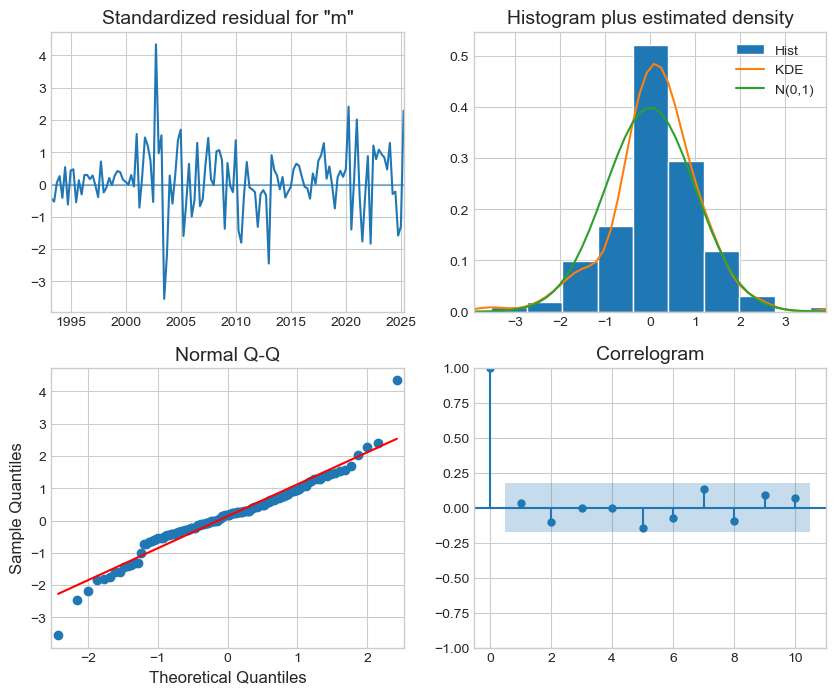

In [96]:
# Import necessary libraries
from statsmodels.tsa.arima.model import ARIMA

# Fit the ARIMA model to the differenced military compensation data (y_diff)
model = ARIMA(comp, order=(1, 1, 1))  # AR(1), I(0), MA(1)
results = model.fit()

# Print the summary of the model
print(results.summary())

# Plot the diagnostics
results.plot_diagnostics(figsize=(10, 8))
plt.show()

                               SARIMAX Results                                
Dep. Variable:          military_comp   No. Observations:                  104
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -163.329
Date:                Sat, 15 Nov 2025   AIC                            332.658
Time:                        16:26:49   BIC                            340.562
Sample:                    03-31-1993   HQIC                           335.859
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9254      0.032     29.167      0.000       0.863       0.988
ma.L1         -0.4738      0.096     -4.956      0.000      -0.661      -0.286
sigma2         1.3819      0.106     12.987      0.0

/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)


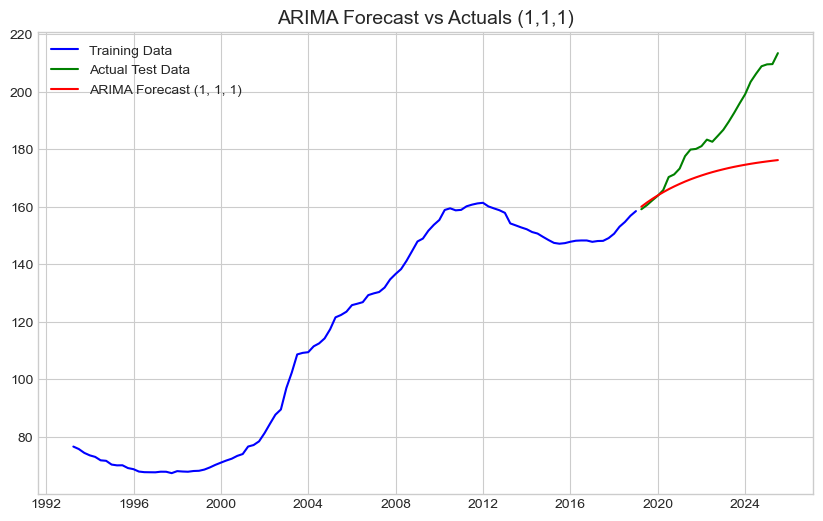

RMSE (1, 1, 1): 18.888
MAE (1, 1, 1): 14.740


In [97]:
# Step 1: Split the data into training and testing sets (80/20 split)
y = comp['military_comp']
split = int(len(y) * 0.8)
y_train, y_test = y[:split], y[split:]

# Step 2: Fit ARIMA model with (1, 1, 1) (no moving average term)
from statsmodels.tsa.arima.model import ARIMA
model_1_1_1 = ARIMA(y_train, order=(1, 1, 1))  # ARIMA(1,1,1)
model_fit_1_1_1 = model_1_1_1.fit()

# Print the summary of the model
print(model_fit_1_1_1.summary())

# Step 3: Forecast the test set
forecast_1_1_1 = model_fit_1_1_1.forecast(steps=len(y_test))

# Convert forecast into a Pandas Series for better alignment
forecast_series_1_1_1 = pd.Series(forecast_1_1_1, index=y_test.index)

# Step 4: Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(y_train, label="Training Data", color='blue')
plt.plot(y_test, label="Actual Test Data", color='green')
plt.plot(forecast_series_1_1_1, label="ARIMA Forecast (1, 1, 1)", color='red')
plt.title("ARIMA Forecast vs Actuals (1,1,1)")
plt.legend()
plt.show()

# Step 5: Evaluate the model with RMSE and MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate RMSE and MAE
rmse_1_1_1 = np.sqrt(mean_squared_error(y_test, forecast_series_1_1_1))
mae_1_1_1 = mean_absolute_error(y_test, forecast_series_1_1_1)

print(f"RMSE (1, 1, 1): {rmse_1_1_1:.3f}")
print(f"MAE (1, 1, 1): {mae_1_1_1:.3f}")

# Save the results for future comparison
arima_1_1_1_forecast = forecast_series_1_1_1  # Store ARIMA forecast for (1,1,1)
arima_1_1_1_rmse = rmse_1_1_1  # Store RMSE for ARIMA (1,1,1)
arima_1_1_1_mae = mae_1_1_1  # Store MAE for ARIMA (1,1,1)
arima_1_1_1_model_summary = model_fit_1_1_1.summary()  # Store model summary for (1,1,1)

# Optionally, store the results in a dictionary for easier access
arima_1_1_1_results = {
    "forecast": arima_1_1_1_forecast,
    "rmse": arima_1_1_1_rmse,
    "mae": arima_1_1_1_mae,
    "model_summary": arima_1_1_1_model_summary
}

# Optionally, save to a CSV or a pickle file
# arima_1_1_1_forecast.to_csv('arima_1_1_1_forecast.csv')
# pickle.dump(arima_1_1_1_results, open('arima_1_1_1_results.pkl', 'wb'))

                               SARIMAX Results                                
Dep. Variable:          military_comp   No. Observations:                  104
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -168.353
Date:                Sat, 15 Nov 2025   AIC                            340.707
Time:                        16:27:02   BIC                            345.976
Sample:                    03-31-1993   HQIC                           342.841
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7394      0.041     17.897      0.000       0.658       0.820
sigma2         1.5272      0.109     14.034      0.000       1.314       1.740
Ljung-Box (L1) (Q):                   5.01   Jarque-

/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)


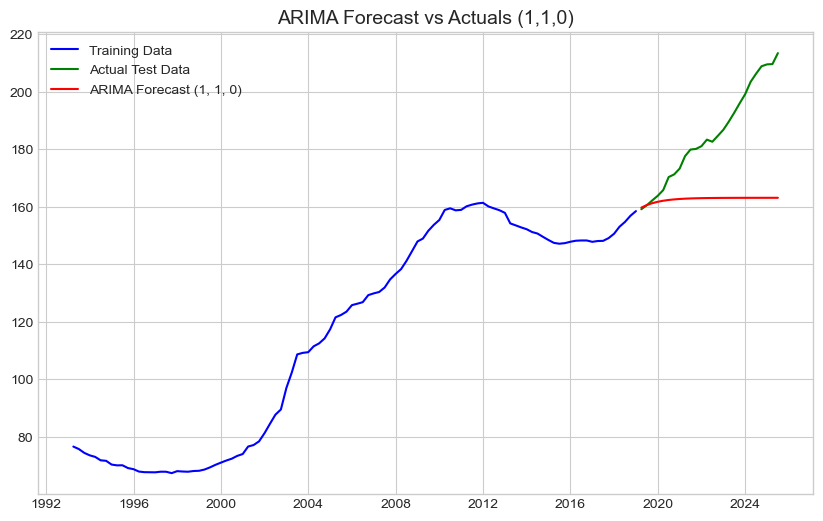

RMSE (1, 1, 0): 27.475
MAE (1, 1, 0): 22.483


In [98]:
# Step 1: Split the data into training and testing sets (80/20 split)
y = comp['military_comp']
split = int(len(y) * 0.8)
y_train, y_test = y[:split], y[split:]

# Step 2: Fit ARIMA model with (1, 1, 0) (no moving average term)
from statsmodels.tsa.arima.model import ARIMA
model_1_1_0 = ARIMA(y_train, order=(1, 1, 0))  # ARIMA(1,1,0)
model_fit_1_1_0 = model_1_1_0.fit()

# Print the summary of the model
print(model_fit_1_1_0.summary())

# Step 3: Forecast the test set
forecast_1_1_0 = model_fit_1_1_0.forecast(steps=len(y_test))

# Convert forecast into a Pandas Series for better alignment
forecast_series_1_1_0 = pd.Series(forecast_1_1_0, index=y_test.index)

# Step 4: Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(y_train, label="Training Data", color='blue')
plt.plot(y_test, label="Actual Test Data", color='green')
plt.plot(forecast_series_1_1_0, label="ARIMA Forecast (1, 1, 0)", color='red')
plt.title("ARIMA Forecast vs Actuals (1,1,0)")
plt.legend()
plt.show()

# Step 5: Evaluate the model with RMSE and MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate RMSE and MAE
rmse_1_1_0 = np.sqrt(mean_squared_error(y_test, forecast_series_1_1_0))
mae_1_1_0 = mean_absolute_error(y_test, forecast_series_1_1_0)

print(f"RMSE (1, 1, 0): {rmse_1_1_0:.3f}")
print(f"MAE (1, 1, 0): {mae_1_1_0:.3f}")

# Save the results for future comparison
arima_1_1_0_forecast = forecast_series_1_1_0  # Store ARIMA forecast for (1,1,0)
arima_1_1_0_rmse = rmse_1_1_0  # Store RMSE for ARIMA (1,1,0)
arima_1_1_0_mae = mae_1_1_0  # Store MAE for ARIMA (1,1,0)
arima_1_1_0_model_summary = model_fit_1_1_0.summary()  # Store model summary for (1,1,0)

# Optionally, store the results in a dictionary for easier access
arima_1_1_0_results = {
    "forecast": arima_1_1_0_forecast,
    "rmse": arima_1_1_0_rmse,
    "mae": arima_1_1_0_mae,
    "model_summary": arima_1_1_0_model_summary
}

# Optionally, save to a CSV or a pickle file
# arima_1_1_0_forecast.to_csv('arima_1_1_0_forecast.csv')
# pickle.dump(arima_1_1_0_results, open('arima_1_1_0_results.pkl', 'wb'))

/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequenc

Best ARIMA model: ARIMA(1, 1, 1)
Best AIC: 332.658


/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequenc

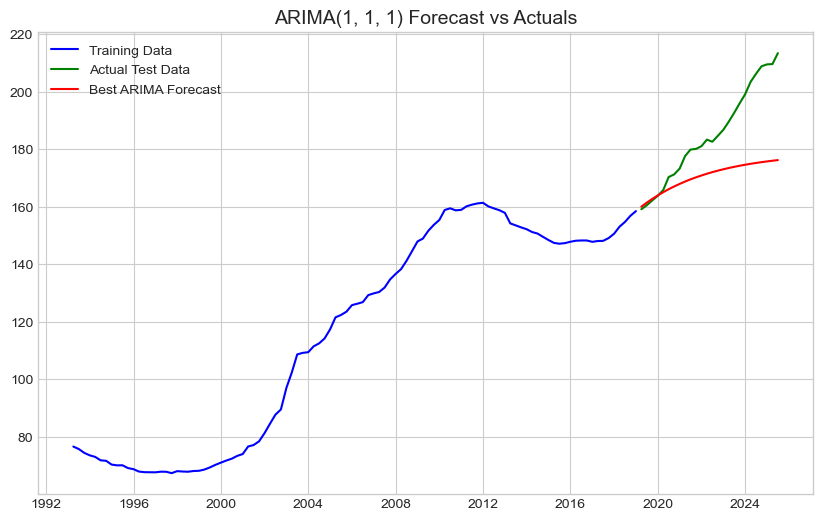

RMSE: 18.888
MAE: 14.740


In [99]:
import itertools
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Define parameter ranges
p_range = range(0, 3)  # p = 0, 1, 2
d_range = range(0, 2)  # d = 0, 1
q_range = range(0, 3)  # q = 0, 1, 2

# Initialize variables to store the best AIC and corresponding parameters
best_aic = np.inf
best_order = None
best_model = None

# Loop over all combinations of p, d, q
for p, d, q in itertools.product(p_range, d_range, q_range):
    try:
        # Fit the ARIMA model
        model = ARIMA(y_train, order=(p, d, q))
        model_fit = model.fit()
        
        # If this model has a lower AIC, update the best values
        if model_fit.aic < best_aic:
            best_aic = model_fit.aic
            best_order = (p, d, q)
            best_model = model_fit
            
    except Exception as e:
        continue  # If the model fails to fit, skip to the next combination

# Output the best model's details
print(f"Best ARIMA model: ARIMA{best_order}")
print(f"Best AIC: {best_aic:.3f}")

# Use the best model to forecast
forecast = best_model.forecast(steps=len(y_test))

# Convert forecast into a Pandas Series for better alignment
forecast_series = pd.Series(forecast, index=y_test.index)

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(y_train, label="Training Data", color='blue')
plt.plot(y_test, label="Actual Test Data", color='green')
plt.plot(forecast_series, label="Best ARIMA Forecast", color='red')
plt.title(f"ARIMA{best_order} Forecast vs Actuals")
plt.legend()
plt.show()

# Evaluate the model with RMSE and MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(y_test, forecast_series))
mae = mean_absolute_error(y_test, forecast_series)

print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")

# ARIMAX with 2 variations 
1. Economical variables
2. Geoplitical variables 

                               SARIMAX Results                                
Dep. Variable:          military_comp   No. Observations:                  103
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -159.160
Date:                Sat, 15 Nov 2025   AIC                            330.320
Time:                        16:27:11   BIC                            346.070
Sample:                    06-30-1993   HQIC                           336.698
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
gdp_growth             -0.1412      0.182     -0.776      0.438      -0.498       0.216
eci_growth_diff         0.0990      0.250      0.396      0.692      -0.392       0.590
inflation_rate_d

/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)


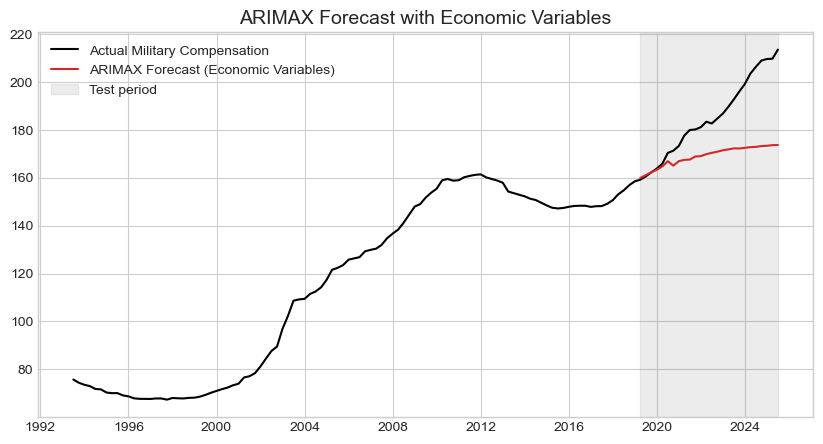

Economic Model - RMSE: 20.509, MAE: 16.181


In [100]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Load the economic data (already preprocessed)
econ = pd.read_csv("economical_ready_for_modeling.csv", parse_dates=["date"], index_col="date")

# Prepare exogenous variables for economic model
exog_econ = econ[['gdp_growth', 'eci_growth_diff', 'inflation_rate_diff']]
y_econ = econ['military_comp']

# Train-test split (80/20)
split_econ = int(len(y_econ) * 0.8)
y_econ_train, y_econ_test = y_econ.iloc[:split_econ], y_econ.iloc[split_econ:]
exog_econ_train, exog_econ_test = exog_econ.iloc[:split_econ], exog_econ.iloc[split_econ:]

# Fit ARIMAX model (1,1,1) on economic variables
model_econ = SARIMAX(y_econ_train, exog=exog_econ_train, order=(1, 1, 1))
results_econ = model_econ.fit()

# Print model summary
print(results_econ.summary())

# Forecast for the test period
forecast_econ = results_econ.get_forecast(steps=len(y_econ_test), exog=exog_econ_test)
forecast_econ_mean = forecast_econ.predicted_mean

# Calculate performance metrics for Economic model
rmse_econ = np.sqrt(mean_squared_error(y_econ_test, forecast_econ_mean))
mae_econ = mean_absolute_error(y_econ_test, forecast_econ_mean)

# Plot the forecast for Economic model
plt.figure(figsize=(10, 5))
plt.plot(y_econ, label='Actual Military Compensation', color='black')
plt.plot(forecast_econ_mean.index, forecast_econ_mean, label='ARIMAX Forecast (Economic Variables)', color='tab:red')
plt.axvspan(y_econ_test.index[0], y_econ_test.index[-1], color='gray', alpha=0.15, label='Test period')
plt.title("ARIMAX Forecast with Economic Variables")
plt.legend()
plt.show()

# Save the results for later comparison
arimax_econ_forecast = forecast_econ_mean  # Store forecast for economic model
arimax_econ_rmse = rmse_econ  # Store RMSE for economic model
arimax_econ_mae = mae_econ  # Store MAE for economic model
arimax_econ_model_summary = results_econ.summary()  # Store model summary for economic model

# Optionally, store the results in a dictionary for easy access
arimax_econ_results = {
    "forecast": arimax_econ_forecast,
    "rmse": arimax_econ_rmse,
    "mae": arimax_econ_mae,
    "model_summary": arimax_econ_model_summary
}

# Optionally, save to a CSV or a pickle file
# arimax_econ_forecast.to_csv('arimax_econ_forecast.csv')
# pickle.dump(arimax_econ_results, open('arimax_econ_results.pkl', 'wb'))

# Print the RMSE and MAE for the Economic model
print(f"Economic Model - RMSE: {rmse_econ:.3f}, MAE: {mae_econ:.3f}")

                               SARIMAX Results                                
Dep. Variable:          military_comp   No. Observations:                  103
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -158.755
Date:                Sat, 15 Nov 2025   AIC                            335.510
Time:                        16:27:16   BIC                            359.135
Sample:                    06-30-1993   HQIC                           345.076
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
geo_risk_logdiff         0.7056      1.299      0.543      0.587      -1.841       3.252
geo_threats              0.0083      0.006      1.475      0.140      -0.003       0.019
geo_acts    

/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


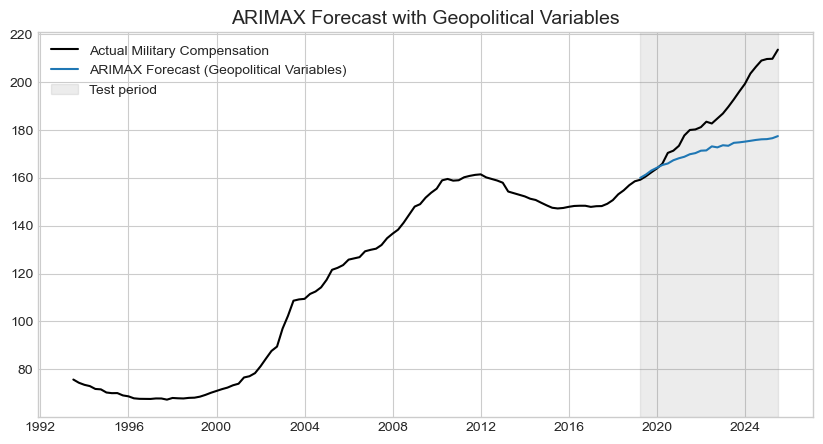

Geopolitical Model - RMSE: 18.552, MAE: 14.472


In [101]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Load the geopolitical data (already preprocessed)
geo = pd.read_csv("geopolitical_ready_for_modeling.csv", parse_dates=["date"], index_col="date")

# Prepare exogenous variables for geopolitical model
exog_geo = geo[['geo_risk_logdiff', 'geo_threats', 'geo_acts', 'geo_risk_china_diff', 'geo_risk_russia', 'geo_risk_usa_logdiff']]
y_geo = geo['military_comp']

# Train-test split (80/20)
split_geo = int(len(y_geo) * 0.8)
y_geo_train, y_geo_test = y_geo.iloc[:split_geo], y_geo.iloc[split_geo:]
exog_geo_train, exog_geo_test = exog_geo.iloc[:split_geo], exog_geo.iloc[split_geo:]

# Fit ARIMAX model (1,1,1) on geopolitical variables
model_geo = SARIMAX(y_geo_train, exog=exog_geo_train, order=(1, 1, 1))
results_geo = model_geo.fit()

# Print model summary
print(results_geo.summary())

# Forecast for the test period
forecast_geo = results_geo.get_forecast(steps=len(y_geo_test), exog=exog_geo_test)
forecast_geo_mean = forecast_geo.predicted_mean

# Calculate performance metrics for Geopolitical model
rmse_geo = np.sqrt(mean_squared_error(y_geo_test, forecast_geo_mean))
mae_geo = mean_absolute_error(y_geo_test, forecast_geo_mean)

# Plot the forecast for Geopolitical model
plt.figure(figsize=(10, 5))
plt.plot(y_geo, label='Actual Military Compensation', color='black')
plt.plot(forecast_geo_mean.index, forecast_geo_mean, label='ARIMAX Forecast (Geopolitical Variables)', color='tab:blue')
plt.axvspan(y_geo_test.index[0], y_geo_test.index[-1], color='gray', alpha=0.15, label='Test period')
plt.title("ARIMAX Forecast with Geopolitical Variables")
plt.legend()
plt.show()

# Save the results for later comparison
arimax_geo_forecast = forecast_geo_mean  # Store forecast for geopolitical model
arimax_geo_rmse = rmse_geo  # Store RMSE for geopolitical model
arimax_geo_mae = mae_geo  # Store MAE for geopolitical model
arimax_geo_model_summary = results_geo.summary()  # Store model summary for geopolitical model

# Optionally, store the results in a dictionary for easy access
arimax_geo_results = {
    "forecast": arimax_geo_forecast,
    "rmse": arimax_geo_rmse,
    "mae": arimax_geo_mae,
    "model_summary": arimax_geo_model_summary
}

# Optionally, save to a CSV or a pickle file
# arimax_geo_forecast.to_csv('arimax_geo_forecast.csv')
# pickle.dump(arimax_geo_results, open('arimax_geo_results.pkl', 'wb'))

# Print the RMSE and MAE for the Geopolitical model
print(f"Geopolitical Model - RMSE: {rmse_geo:.3f}, MAE: {mae_geo:.3f}")

# ARIMAX with ALL Variables

/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:          military_comp   No. Observations:                  103
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -154.921
Date:                Sat, 15 Nov 2025   AIC                            333.842
Time:                        16:27:24   BIC                            365.342
Sample:                    06-30-1993   HQIC                           346.597
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
gdp_growth              -0.1634      0.204     -0.802      0.422      -0.563       0.236
eci_growth_diff          0.2168      0.267      0.813      0.416      -0.306       0.740
inflation_ra

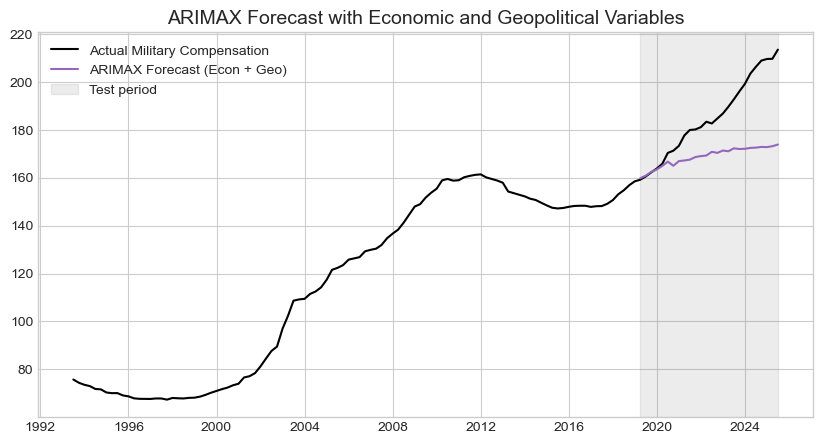

Combined Model - RMSE: 20.713, MAE: 16.341


In [102]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Load the economic and geopolitical data (already preprocessed)
econ = pd.read_csv("economical_ready_for_modeling.csv", parse_dates=["date"], index_col="date")
geo = pd.read_csv("geopolitical_ready_for_modeling.csv", parse_dates=["date"], index_col="date")

# Ensure both datasets are aligned on the same date range (trim to common range)
common_start = max(econ.index.min(), geo.index.min())
common_end = min(econ.index.max(), geo.index.max())

econ_common = econ.loc[common_start:common_end]
geo_common = geo.loc[common_start:common_end]

# Prepare exogenous variables for the combined model
exog_combined = pd.concat([
    econ_common[['gdp_growth', 'eci_growth_diff', 'inflation_rate_diff']],
    geo_common[['geo_risk_logdiff', 'geo_threats', 'geo_acts', 'geo_risk_china_diff', 'geo_risk_russia', 'geo_risk_usa_logdiff']]
], axis=1)

# Prepare target variable (using military compensation from the geopolitical dataset)
y_combined = geo_common['military_comp']  # Using geo dataset's military_comp

# Train-test split (80/20)
split_combined = int(len(y_combined) * 0.8)
y_train, y_test = y_combined.iloc[:split_combined], y_combined.iloc[split_combined:]
exog_train, exog_test = exog_combined.iloc[:split_combined], exog_combined.iloc[split_combined:]

# Fit ARIMAX model (1, 1, 1) on combined economic and geopolitical variables
model_combined = SARIMAX(y_train, exog=exog_train, order=(1, 1, 1))
results_combined = model_combined.fit()

# Print model summary
print(results_combined.summary())

# Forecast for the test period
forecast_combined = results_combined.get_forecast(steps=len(y_test), exog=exog_test)
forecast_combined_mean = forecast_combined.predicted_mean

# Calculate performance metrics for combined model
rmse_combined = np.sqrt(mean_squared_error(y_test, forecast_combined_mean))
mae_combined = mean_absolute_error(y_test, forecast_combined_mean)

# Plot the forecast for combined model
plt.figure(figsize=(10, 5))
plt.plot(y_combined, label='Actual Military Compensation', color='black')
plt.plot(forecast_combined_mean.index, forecast_combined_mean, label='ARIMAX Forecast (Econ + Geo)', color='tab:purple')
plt.axvspan(y_test.index[0], y_test.index[-1], color='gray', alpha=0.15, label='Test period')
plt.title("ARIMAX Forecast with Economic and Geopolitical Variables")
plt.legend()
plt.show()

# Save the results for later comparison
arimax_combined_forecast = forecast_combined_mean  # Store forecast for combined model
arimax_combined_rmse = rmse_combined  # Store RMSE for combined model
arimax_combined_mae = mae_combined  # Store MAE for combined model
arimax_combined_model_summary = results_combined.summary()  # Store model summary for combined model

# Optionally, store the results in a dictionary for easy access
arimax_combined_results = {
    "forecast": arimax_combined_forecast,
    "rmse": arimax_combined_rmse,
    "mae": arimax_combined_mae,
    "model_summary": arimax_combined_model_summary
}

# Optionally, save to a CSV or a pickle file
# arimax_combined_forecast.to_csv('arimax_combined_forecast.csv')
# pickle.dump(arimax_combined_results, open('arimax_combined_results.pkl', 'wb'))

# Print the RMSE and MAE for the combined model
print(f"Combined Model - RMSE: {rmse_combined:.3f}, MAE: {mae_combined:.3f}")

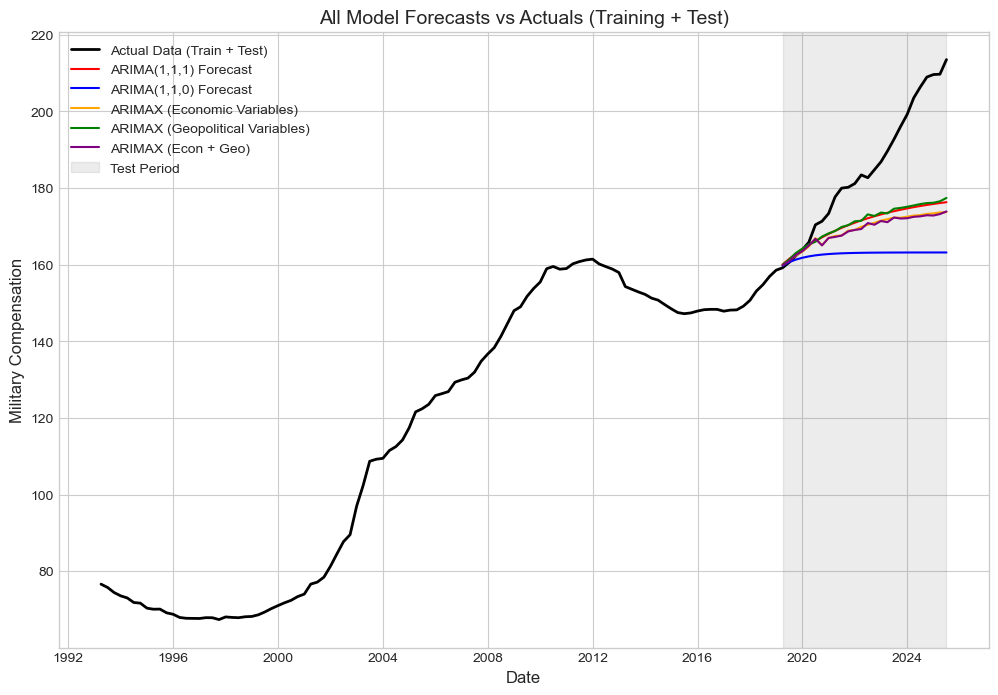

                 Model   RMSE    MAE
0         ARIMA(1,1,1) 18.888 14.740
1         ARIMA(1,1,0) 27.475 22.483
2    ARIMAX (Economic) 20.509 16.181
3         ARIMAX (Geo) 18.552 14.472
4  ARIMAX (Econ + Geo) 20.713 16.341


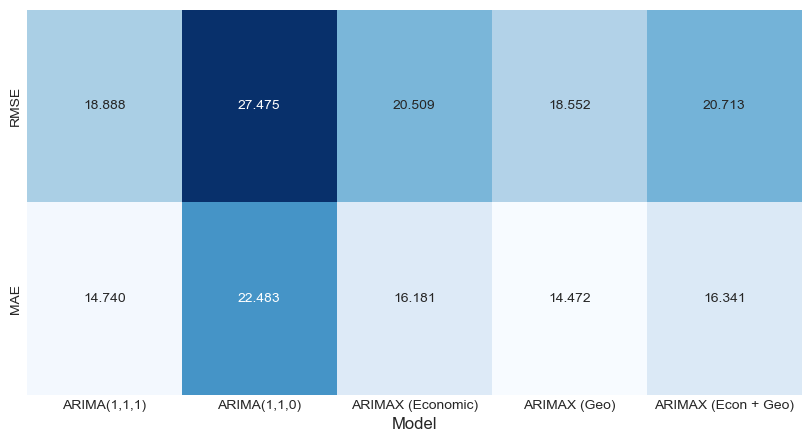

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Assuming you have already saved the following results:
# 1. ARIMA(1,1,1) - forecast, rmse, mae
# 2. ARIMA(1,1,0) - forecast, rmse, mae
# 3. ARIMAX (Economic Variables) - forecast, rmse, mae
# 4. ARIMAX (Geopolitical Variables) - forecast, rmse, mae
# 5. ARIMAX (Both) - forecast, rmse, mae

# Put all the forecast results into a DataFrame for plotting
plt.figure(figsize=(12, 8))

# Plot the actual and forecast data (including both training and test data)
plt.plot(y, label='Actual Data (Train + Test)', color='black', linewidth=2)
plt.plot(forecast_1_1_1.index, forecast_1_1_1, label='ARIMA(1,1,1) Forecast', color='red')
plt.plot(forecast_1_1_0.index, forecast_1_1_0, label='ARIMA(1,1,0) Forecast', color='blue')
plt.plot(forecast_econ_mean.index, forecast_econ_mean, label='ARIMAX (Economic Variables)', color='orange')
plt.plot(forecast_geo_mean.index, forecast_geo_mean, label='ARIMAX (Geopolitical Variables)', color='green')
plt.plot(forecast_combined_mean.index, forecast_combined_mean, label='ARIMAX (Econ + Geo)', color='purple')

# Highlight the test period for better visualization
plt.axvspan(y_test.index[0], y_test.index[-1], color='gray', alpha=0.15, label='Test Period')

# Set plot title and labels
plt.title("All Model Forecasts vs Actuals (Training + Test)")
plt.xlabel("Date")
plt.ylabel("Military Compensation")
plt.legend()

# Display the plot
plt.show()

# Prepare the comparison table for RMSE and MAE
comparison_data = {
    'Model': ['ARIMA(1,1,1)', 'ARIMA(1,1,0)', 'ARIMAX (Economic)', 'ARIMAX (Geo)', 'ARIMAX (Econ + Geo)'],
    'RMSE': [rmse_1_1_1, rmse_1_1_0, rmse_econ, rmse_geo, rmse_combined],
    'MAE': [mae_1_1_1, mae_1_1_0, mae_econ, mae_geo, mae_combined]
}

comparison_df = pd.DataFrame(comparison_data)

# Display the table with a heatmap for better visualization
import seaborn as sns
sns.heatmap(comparison_df.set_index('Model').T, annot=True, cmap="Blues", cbar=False, fmt=".3f")

# Show the comparison table
print(comparison_df)

# IDEA FOR TOMMOROW:

### 1. agree all the dates from the start from 1992 ( slice some and impute for the other)
### 2. try arimax models with 1,2,1(they result really better!) and try to justify it

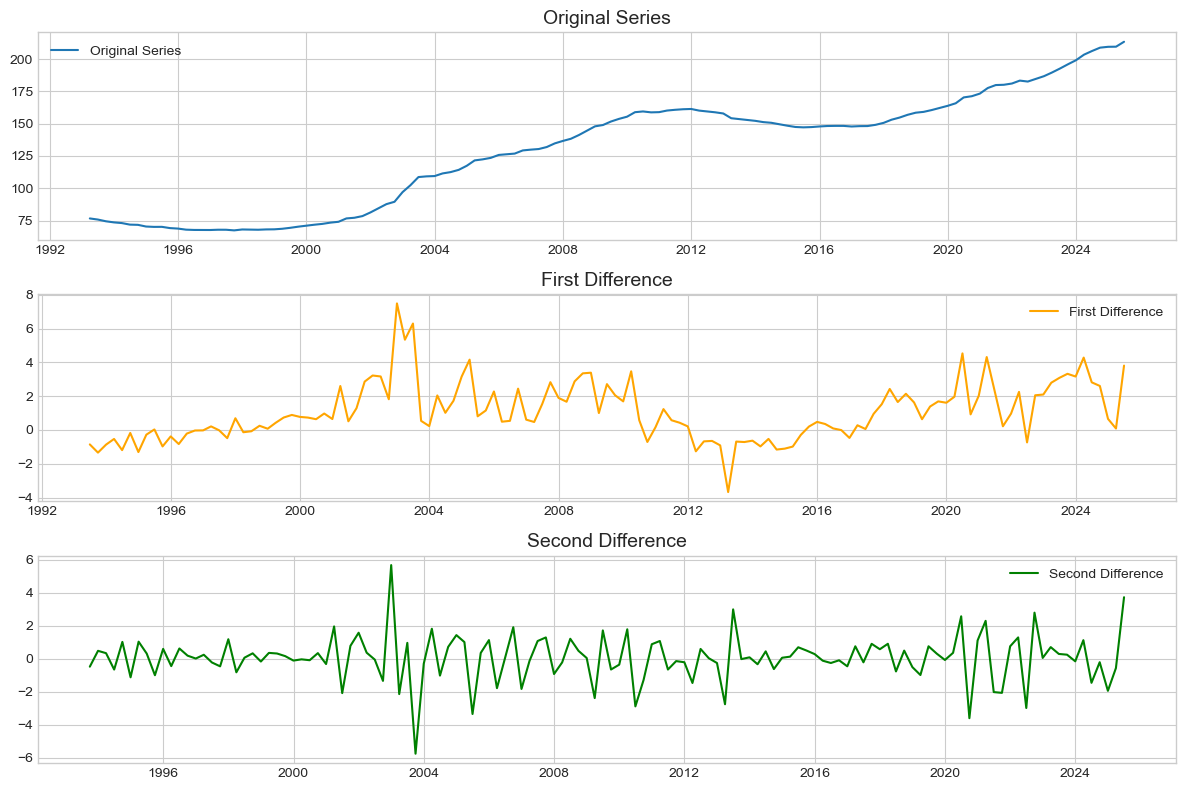

ADF Test for Original Series:
  ADF Statistic: -0.0632
  p-value: 0.9530
  Critical Values: {'1%': np.float64(-3.4833462346078936), '5%': np.float64(-2.8847655969877666), '10%': np.float64(-2.5791564575459813)}
  Null Hypothesis: The series has a unit root (non-stationary)
  Conclusion: Fail to Reject

ADF Test for First Difference:
  ADF Statistic: -2.9915
  p-value: 0.0357
  Critical Values: {'1%': np.float64(-3.4833462346078936), '5%': np.float64(-2.8847655969877666), '10%': np.float64(-2.5791564575459813)}
  Null Hypothesis: The series has a unit root (non-stationary)
  Conclusion: Reject

ADF Test for Second Difference:
  ADF Statistic: -5.7551
  p-value: 0.0000
  Critical Values: {'1%': np.float64(-3.486055829282407), '5%': np.float64(-2.8859430324074076), '10%': np.float64(-2.5797850694444446)}
  Null Hypothesis: The series has a unit root (non-stationary)
  Conclusion: Reject



In [104]:
import matplotlib.pyplot as plt

# Original series
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(y, label='Original Series')
plt.title('Original Series')
plt.legend()

# First difference
y_first_diff = y.diff().dropna()  # First difference
plt.subplot(3, 1, 2)
plt.plot(y_first_diff, label='First Difference', color='orange')
plt.title('First Difference')
plt.legend()

# Second difference
y_second_diff = y_first_diff.diff().dropna()  # Second difference
plt.subplot(3, 1, 3)
plt.plot(y_second_diff, label='Second Difference', color='green')
plt.title('Second Difference')
plt.legend()

plt.tight_layout()
plt.show()
from statsmodels.tsa.stattools import adfuller

# Function to perform ADF test and print results
def adf_test(series, label="Series"):
    print(f"ADF Test for {label}:")
    result = adfuller(series)
    print(f"  ADF Statistic: {result[0]:.4f}")
    print(f"  p-value: {result[1]:.4f}")
    print(f"  Critical Values: {result[4]}")
    print(f"  Null Hypothesis: The series has a unit root (non-stationary)")
    print(f"  Conclusion: {'Reject' if result[1] < 0.05 else 'Fail to Reject'}\n")

# 1. ADF Test for Original Series
adf_test(y, "Original Series")

# 2. ADF Test for First Difference
y_first_diff = y.diff().dropna()  # First difference
adf_test(y_first_diff, "First Difference")

# 3. ADF Test for Second Difference
y_second_diff = y_first_diff.diff().dropna()  # Second difference
adf_test(y_second_diff, "Second Difference")

                               SARIMAX Results                                
Dep. Variable:          military_comp   No. Observations:                  104
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -162.427
Date:                Sat, 15 Nov 2025   AIC                            330.854
Time:                        16:28:57   BIC                            338.729
Sample:                    03-31-1993   HQIC                           334.043
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2076      0.115      1.808      0.071      -0.017       0.433
ma.L1         -0.6912      0.073     -9.507      0.000      -0.834      -0.549
sigma2         1.4094      0.111     12.688      0.0

/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)


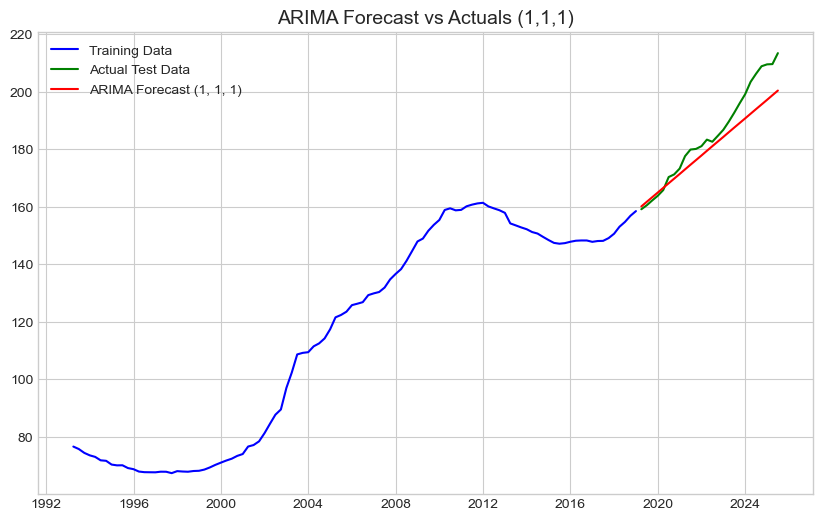

RMSE (1, 1, 1): 6.699
MAE (1, 1, 1): 5.178


In [105]:
# Step 1: Split the data into training and testing sets (80/20 split)
y = comp['military_comp']
split = int(len(y) * 0.8)
y_train, y_test = y[:split], y[split:]

# Step 2: Fit ARIMA model with (1, 1, 1) (no moving average term)
from statsmodels.tsa.arima.model import ARIMA
model_1_1_1 = ARIMA(y_train, order=(1, 2, 1))  # ARIMA(1,1,1)
model_fit_1_1_1 = model_1_1_1.fit()

# Print the summary of the model
print(model_fit_1_1_1.summary())

# Step 3: Forecast the test set
forecast_1_1_1 = model_fit_1_1_1.forecast(steps=len(y_test))

# Convert forecast into a Pandas Series for better alignment
forecast_series_1_1_1 = pd.Series(forecast_1_1_1, index=y_test.index)

# Step 4: Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(y_train, label="Training Data", color='blue')
plt.plot(y_test, label="Actual Test Data", color='green')
plt.plot(forecast_series_1_1_1, label="ARIMA Forecast (1, 2, 1)", color='red')
plt.title("ARIMA Forecast vs Actuals (1,2,1)")
plt.legend()
plt.show()

# Step 5: Evaluate the model with RMSE and MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate RMSE and MAE
rmse_1_1_1 = np.sqrt(mean_squared_error(y_test, forecast_series_1_1_1))
mae_1_1_1 = mean_absolute_error(y_test, forecast_series_1_1_1)

print(f"RMSE (1, 1, 1): {rmse_1_1_1:.3f}")
print(f"MAE (1, 1, 1): {mae_1_1_1:.3f}")

# Save the results for future comparison
arima_1_1_1_forecast = forecast_series_1_1_1  # Store ARIMA forecast for (1,1,1)
arima_1_1_1_rmse = rmse_1_1_1  # Store RMSE for ARIMA (1,1,1)
arima_1_1_1_mae = mae_1_1_1  # Store MAE for ARIMA (1,1,1)
arima_1_1_1_model_summary = model_fit_1_1_1.summary()  # Store model summary for (1,1,1)

# Optionally, store the results in a dictionary for easier access
arima_1_1_1_results = {
    "forecast": arima_1_1_1_forecast,
    "rmse": arima_1_1_1_rmse,
    "mae": arima_1_1_1_mae,
    "model_summary": arima_1_1_1_model_summary
}

# Optionally, save to a CSV or a pickle file
# arima_1_1_1_forecast.to_csv('arima_1_1_1_forecast.csv')
# pickle.dump(arima_1_1_1_results, open('arima_1_1_1_results.pkl', 'wb'))

                               SARIMAX Results                                
Dep. Variable:          military_comp   No. Observations:                  104
Model:                 ARIMA(1, 2, 0)   Log Likelihood                -167.039
Date:                Sat, 15 Nov 2025   AIC                            338.077
Time:                        16:29:20   BIC                            343.327
Sample:                    03-31-1993   HQIC                           340.203
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3459      0.080     -4.305      0.000      -0.503      -0.188
sigma2         1.5467      0.121     12.735      0.000       1.309       1.785
Ljung-Box (L1) (Q):                   0.63   Jarque-

/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)


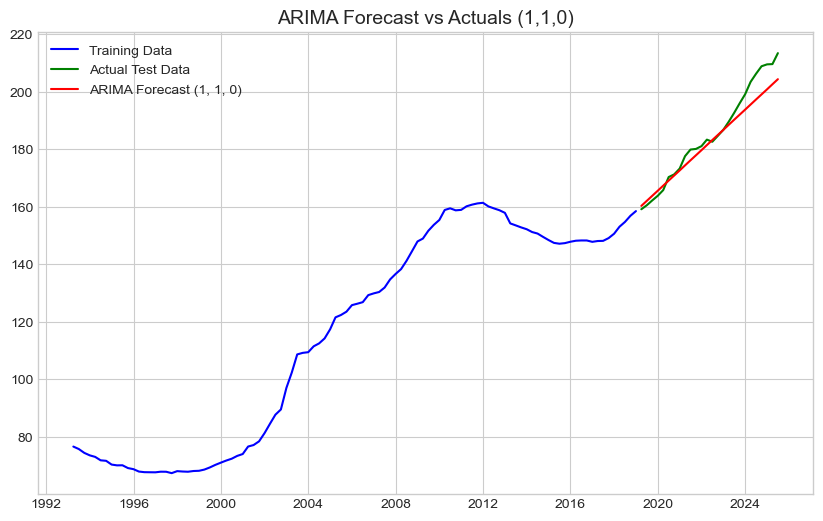

RMSE (1, 1, 0): 4.580
MAE (1, 1, 0): 3.363


In [106]:
# Step 1: Split the data into training and testing sets (80/20 split)
y = comp['military_comp']
split = int(len(y) * 0.8)
y_train, y_test = y[:split], y[split:]

# Step 2: Fit ARIMA model with (1, 1, 0) (no moving average term)
from statsmodels.tsa.arima.model import ARIMA
model_1_1_0 = ARIMA(y_train, order=(1, 2, 0))  # ARIMA(1,1,0)
model_fit_1_1_0 = model_1_1_0.fit()

# Print the summary of the model
print(model_fit_1_1_0.summary())

# Step 3: Forecast the test set
forecast_1_1_0 = model_fit_1_1_0.forecast(steps=len(y_test))

# Convert forecast into a Pandas Series for better alignment
forecast_series_1_1_0 = pd.Series(forecast_1_1_0, index=y_test.index)

# Step 4: Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(y_train, label="Training Data", color='blue')
plt.plot(y_test, label="Actual Test Data", color='green')
plt.plot(forecast_series_1_1_0, label="ARIMA Forecast (1, 2, 0)", color='red')
plt.title("ARIMA Forecast vs Actuals (1,2,0)")
plt.legend()
plt.show()

# Step 5: Evaluate the model with RMSE and MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate RMSE and MAE
rmse_1_1_0 = np.sqrt(mean_squared_error(y_test, forecast_series_1_1_0))
mae_1_1_0 = mean_absolute_error(y_test, forecast_series_1_1_0)

print(f"RMSE (1, 1, 0): {rmse_1_1_0:.3f}")
print(f"MAE (1, 1, 0): {mae_1_1_0:.3f}")

# Save the results for future comparison
arima_1_1_0_forecast = forecast_series_1_1_0  # Store ARIMA forecast for (1,1,0)
arima_1_1_0_rmse = rmse_1_1_0  # Store RMSE for ARIMA (1,1,0)
arima_1_1_0_mae = mae_1_1_0  # Store MAE for ARIMA (1,1,0)
arima_1_1_0_model_summary = model_fit_1_1_0.summary()  # Store model summary for (1,1,0)

# Optionally, store the results in a dictionary for easier access
arima_1_1_0_results = {
    "forecast": arima_1_1_0_forecast,
    "rmse": arima_1_1_0_rmse,
    "mae": arima_1_1_0_mae,
    "model_summary": arima_1_1_0_model_summary
}

# Optionally, save to a CSV or a pickle file
# arima_1_1_0_forecast.to_csv('arima_1_1_0_forecast.csv')
# pickle.dump(arima_1_1_0_results, open('arima_1_1_0_results.pkl', 'wb'))

                               SARIMAX Results                                
Dep. Variable:          military_comp   No. Observations:                  103
Model:               SARIMAX(1, 2, 1)   Log Likelihood                -157.947
Date:                Sat, 15 Nov 2025   AIC                            327.893
Time:                        16:31:06   BIC                            343.584
Sample:                    06-30-1993   HQIC                           334.245
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
gdp_growth             -0.1598      0.171     -0.935      0.350      -0.495       0.175
eci_growth_diff         0.0773      0.225      0.343      0.732      -0.365       0.519
inflation_rate_d

/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)


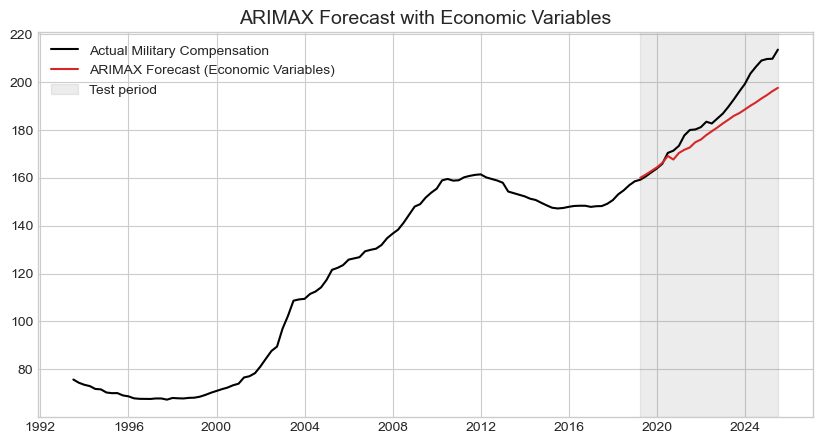

Economic Model - RMSE: 8.393, MAE: 6.616


In [108]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Load the economic data (already preprocessed)
econ = pd.read_csv("economical_ready_for_modeling.csv", parse_dates=["date"], index_col="date")

# Prepare exogenous variables for economic model
exog_econ = econ[['gdp_growth', 'eci_growth_diff', 'inflation_rate_diff']]
y_econ = econ['military_comp']

# Train-test split (80/20)
split_econ = int(len(y_econ) * 0.8)
y_econ_train, y_econ_test = y_econ.iloc[:split_econ], y_econ.iloc[split_econ:]
exog_econ_train, exog_econ_test = exog_econ.iloc[:split_econ], exog_econ.iloc[split_econ:]

# Fit ARIMAX model (1,1,1) on economic variables
model_econ = SARIMAX(y_econ_train, exog=exog_econ_train, order=(1, 2, 1))
results_econ = model_econ.fit()

# Print model summary
print(results_econ.summary())

# Forecast for the test period
forecast_econ = results_econ.get_forecast(steps=len(y_econ_test), exog=exog_econ_test)
forecast_econ_mean = forecast_econ.predicted_mean

# Calculate performance metrics for Economic model
rmse_econ = np.sqrt(mean_squared_error(y_econ_test, forecast_econ_mean))
mae_econ = mean_absolute_error(y_econ_test, forecast_econ_mean)

# Plot the forecast for Economic model
plt.figure(figsize=(10, 5))
plt.plot(y_econ, label='Actual Military Compensation', color='black')
plt.plot(forecast_econ_mean.index, forecast_econ_mean, label='ARIMAX Forecast (Economic Variables)', color='tab:red')
plt.axvspan(y_econ_test.index[0], y_econ_test.index[-1], color='gray', alpha=0.15, label='Test period')
plt.title("ARIMAX Forecast with Economic Variables")
plt.legend()
plt.show()

# Save the results for later comparison
arimax_econ_forecast = forecast_econ_mean  # Store forecast for economic model
arimax_econ_rmse = rmse_econ  # Store RMSE for economic model
arimax_econ_mae = mae_econ  # Store MAE for economic model
arimax_econ_model_summary = results_econ.summary()  # Store model summary for economic model

# Optionally, store the results in a dictionary for easy access
arimax_econ_results = {
    "forecast": arimax_econ_forecast,
    "rmse": arimax_econ_rmse,
    "mae": arimax_econ_mae,
    "model_summary": arimax_econ_model_summary
}

# Optionally, save to a CSV or a pickle file
# arimax_econ_forecast.to_csv('arimax_econ_forecast.csv')
# pickle.dump(arimax_econ_results, open('arimax_econ_results.pkl', 'wb'))

# Print the RMSE and MAE for the Economic model
print(f"Economic Model - RMSE: {rmse_econ:.3f}, MAE: {mae_econ:.3f}")

                               SARIMAX Results                                
Dep. Variable:          military_comp   No. Observations:                  103
Model:               SARIMAX(1, 2, 1)   Log Likelihood                -157.883
Date:                Sat, 15 Nov 2025   AIC                            333.766
Time:                        16:32:01   BIC                            357.302
Sample:                    06-30-1993   HQIC                           343.294
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
geo_risk_logdiff         0.8008      1.269      0.631      0.528      -1.687       3.288
geo_threats              0.0076      0.006      1.249      0.212      -0.004       0.019
geo_acts    

/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)


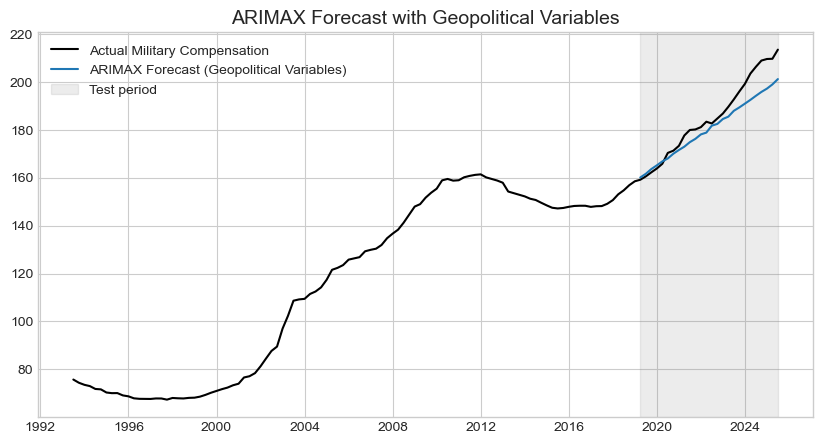

Geopolitical Model - RMSE: 6.593, MAE: 5.117


In [109]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Load the geopolitical data (already preprocessed)
geo = pd.read_csv("geopolitical_ready_for_modeling.csv", parse_dates=["date"], index_col="date")

# Prepare exogenous variables for geopolitical model
exog_geo = geo[['geo_risk_logdiff', 'geo_threats', 'geo_acts', 'geo_risk_china_diff', 'geo_risk_russia', 'geo_risk_usa_logdiff']]
y_geo = geo['military_comp']

# Train-test split (80/20)
split_geo = int(len(y_geo) * 0.8)
y_geo_train, y_geo_test = y_geo.iloc[:split_geo], y_geo.iloc[split_geo:]
exog_geo_train, exog_geo_test = exog_geo.iloc[:split_geo], exog_geo.iloc[split_geo:]

# Fit ARIMAX model (1,1,1) on geopolitical variables
model_geo = SARIMAX(y_geo_train, exog=exog_geo_train, order=(1, 2, 1))
results_geo = model_geo.fit()

# Print model summary
print(results_geo.summary())

# Forecast for the test period
forecast_geo = results_geo.get_forecast(steps=len(y_geo_test), exog=exog_geo_test)
forecast_geo_mean = forecast_geo.predicted_mean

# Calculate performance metrics for Geopolitical model
rmse_geo = np.sqrt(mean_squared_error(y_geo_test, forecast_geo_mean))
mae_geo = mean_absolute_error(y_geo_test, forecast_geo_mean)

# Plot the forecast for Geopolitical model
plt.figure(figsize=(10, 5))
plt.plot(y_geo, label='Actual Military Compensation', color='black')
plt.plot(forecast_geo_mean.index, forecast_geo_mean, label='ARIMAX Forecast (Geopolitical Variables)', color='tab:blue')
plt.axvspan(y_geo_test.index[0], y_geo_test.index[-1], color='gray', alpha=0.15, label='Test period')
plt.title("ARIMAX Forecast with Geopolitical Variables")
plt.legend()
plt.show()

# Save the results for later comparison
arimax_geo_forecast = forecast_geo_mean  # Store forecast for geopolitical model
arimax_geo_rmse = rmse_geo  # Store RMSE for geopolitical model
arimax_geo_mae = mae_geo  # Store MAE for geopolitical model
arimax_geo_model_summary = results_geo.summary()  # Store model summary for geopolitical model

# Optionally, store the results in a dictionary for easy access
arimax_geo_results = {
    "forecast": arimax_geo_forecast,
    "rmse": arimax_geo_rmse,
    "mae": arimax_geo_mae,
    "model_summary": arimax_geo_model_summary
}

# Optionally, save to a CSV or a pickle file
# arimax_geo_forecast.to_csv('arimax_geo_forecast.csv')
# pickle.dump(arimax_geo_results, open('arimax_geo_results.pkl', 'wb'))

# Print the RMSE and MAE for the Geopolitical model
print(f"Geopolitical Model - RMSE: {rmse_geo:.3f}, MAE: {mae_geo:.3f}")

/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:          military_comp   No. Observations:                  103
Model:               SARIMAX(1, 2, 1)   Log Likelihood                -153.617
Date:                Sat, 15 Nov 2025   AIC                            331.235
Time:                        16:33:25   BIC                            362.616
Sample:                    06-30-1993   HQIC                           343.939
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
gdp_growth              -0.2006      0.193     -1.038      0.299      -0.579       0.178
eci_growth_diff          0.1933      0.231      0.836      0.403      -0.260       0.646
inflation_ra

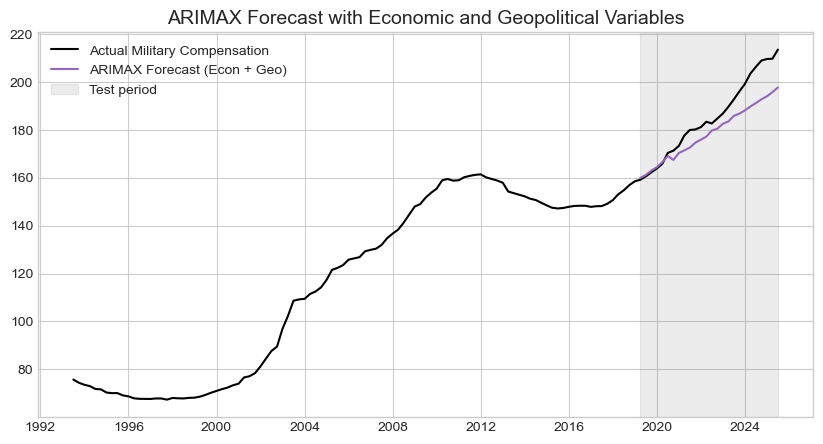

Combined Model - RMSE: 8.598, MAE: 6.812


In [113]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Load the economic and geopolitical data (already preprocessed)
econ = pd.read_csv("economical_ready_for_modeling.csv", parse_dates=["date"], index_col="date")
geo = pd.read_csv("geopolitical_ready_for_modeling.csv", parse_dates=["date"], index_col="date")

# Ensure both datasets are aligned on the same date range (trim to common range)
common_start = max(econ.index.min(), geo.index.min())
common_end = min(econ.index.max(), geo.index.max())

econ_common = econ.loc[common_start:common_end]
geo_common = geo.loc[common_start:common_end]

# Prepare exogenous variables for the combined model
exog_combined = pd.concat([
    econ_common[['gdp_growth', 'eci_growth_diff', 'inflation_rate_diff']],
    geo_common[['geo_risk_logdiff', 'geo_threats', 'geo_acts', 'geo_risk_china_diff', 'geo_risk_russia', 'geo_risk_usa_logdiff']]
], axis=1)

# Prepare target variable (using military compensation from the geopolitical dataset)
y_combined = geo_common['military_comp']  # Using geo dataset's military_comp

# Train-test split (80/20)
split_combined = int(len(y_combined) * 0.8)
y_train, y_test = y_combined.iloc[:split_combined], y_combined.iloc[split_combined:]
exog_train, exog_test = exog_combined.iloc[:split_combined], exog_combined.iloc[split_combined:]

# Fit ARIMAX model (1, 1, 1) on combined economic and geopolitical variables
model_combined = SARIMAX(y_train, exog=exog_train, order=(1, 2, 1))
results_combined = model_combined.fit()

# Print model summary
print(results_combined.summary())

# Forecast for the test period
forecast_combined = results_combined.get_forecast(steps=len(y_test), exog=exog_test)
forecast_combined_mean = forecast_combined.predicted_mean

# Calculate performance metrics for combined model
rmse_combined = np.sqrt(mean_squared_error(y_test, forecast_combined_mean))
mae_combined = mean_absolute_error(y_test, forecast_combined_mean)

# Plot the forecast for combined model
plt.figure(figsize=(10, 5))
plt.plot(y_combined, label='Actual Military Compensation', color='black')
plt.plot(forecast_combined_mean.index, forecast_combined_mean, label='ARIMAX Forecast (Econ + Geo)', color='tab:purple')
plt.axvspan(y_test.index[0], y_test.index[-1], color='gray', alpha=0.15, label='Test period')
plt.title("ARIMAX Forecast with Economic and Geopolitical Variables")
plt.legend()
plt.show()

# Save the results for later comparison
arimax_combined_forecast = forecast_combined_mean  # Store forecast for combined model
arimax_combined_rmse = rmse_combined  # Store RMSE for combined model
arimax_combined_mae = mae_combined  # Store MAE for combined model
arimax_combined_model_summary = results_combined.summary()  # Store model summary for combined model

# Optionally, store the results in a dictionary for easy access
arimax_combined_results = {
    "forecast": arimax_combined_forecast,
    "rmse": arimax_combined_rmse,
    "mae": arimax_combined_mae,
    "model_summary": arimax_combined_model_summary
}

# Optionally, save to a CSV or a pickle file
# arimax_combined_forecast.to_csv('arimax_combined_forecast.csv')
# pickle.dump(arimax_combined_results, open('arimax_combined_results.pkl', 'wb'))

# Print the RMSE and MAE for the combined model
print(f"Combined Model - RMSE: {rmse_combined:.3f}, MAE: {mae_combined:.3f}")

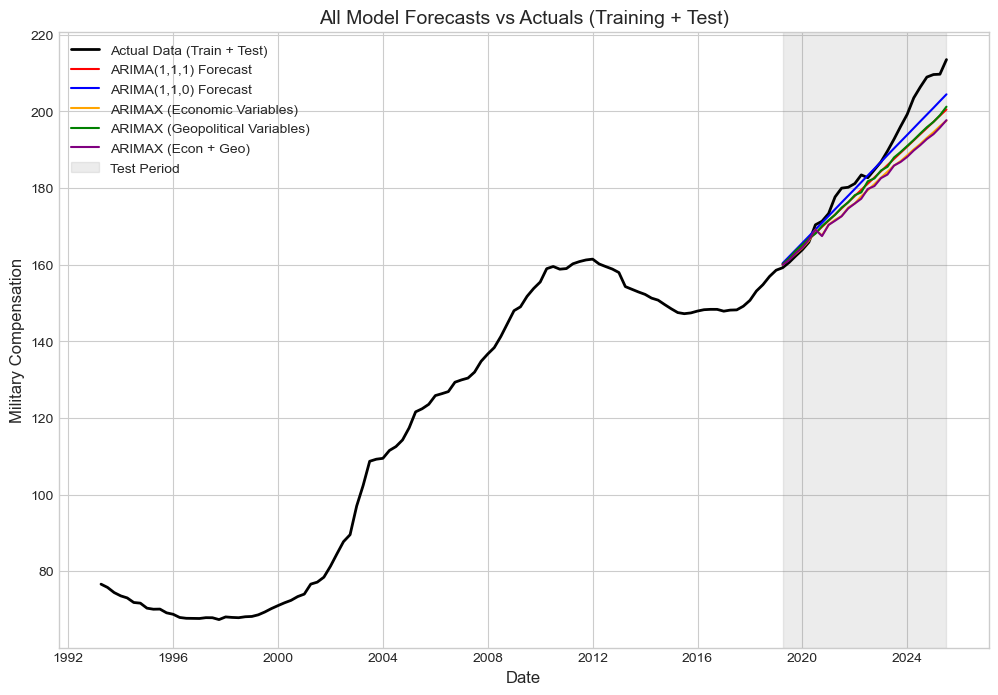

                 Model  RMSE   MAE
0         ARIMA(1,1,1) 6.699 5.178
1         ARIMA(1,1,0) 4.580 3.363
2    ARIMAX (Economic) 8.393 6.616
3         ARIMAX (Geo) 6.593 5.117
4  ARIMAX (Econ + Geo) 8.598 6.812


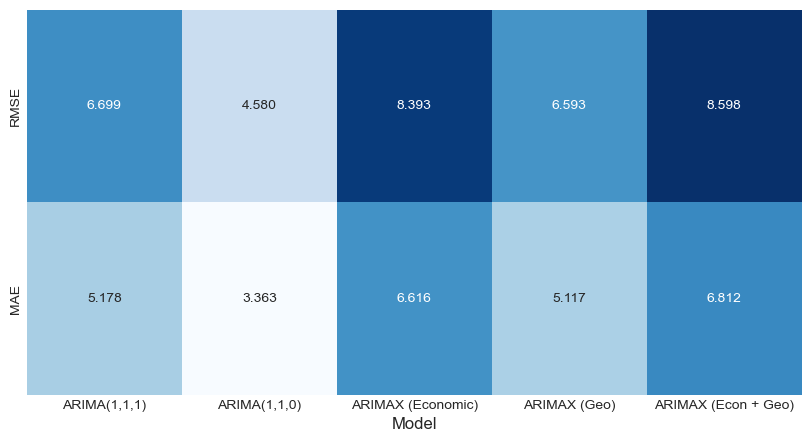

In [114]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Assuming you have already saved the following results:
# 1. ARIMA(1,1,1) - forecast, rmse, mae
# 2. ARIMA(1,1,0) - forecast, rmse, mae
# 3. ARIMAX (Economic Variables) - forecast, rmse, mae
# 4. ARIMAX (Geopolitical Variables) - forecast, rmse, mae
# 5. ARIMAX (Both) - forecast, rmse, mae

# Put all the forecast results into a DataFrame for plotting
plt.figure(figsize=(12, 8))

# Plot the actual and forecast data (including both training and test data)
plt.plot(y, label='Actual Data (Train + Test)', color='black', linewidth=2)
plt.plot(forecast_1_1_1.index, forecast_1_1_1, label='ARIMA(1,1,1) Forecast', color='red')
plt.plot(forecast_1_1_0.index, forecast_1_1_0, label='ARIMA(1,1,0) Forecast', color='blue')
plt.plot(forecast_econ_mean.index, forecast_econ_mean, label='ARIMAX (Economic Variables)', color='orange')
plt.plot(forecast_geo_mean.index, forecast_geo_mean, label='ARIMAX (Geopolitical Variables)', color='green')
plt.plot(forecast_combined_mean.index, forecast_combined_mean, label='ARIMAX (Econ + Geo)', color='purple')

# Highlight the test period for better visualization
plt.axvspan(y_test.index[0], y_test.index[-1], color='gray', alpha=0.15, label='Test Period')

# Set plot title and labels
plt.title("All Model Forecasts vs Actuals (Training + Test)")
plt.xlabel("Date")
plt.ylabel("Military Compensation")
plt.legend()

# Display the plot
plt.show()

# Prepare the comparison table for RMSE and MAE
comparison_data = {
    'Model': ['ARIMA(1,1,1)', 'ARIMA(1,1,0)', 'ARIMAX (Economic)', 'ARIMAX (Geo)', 'ARIMAX (Econ + Geo)'],
    'RMSE': [rmse_1_1_1, rmse_1_1_0, rmse_econ, rmse_geo, rmse_combined],
    'MAE': [mae_1_1_1, mae_1_1_0, mae_econ, mae_geo, mae_combined]
}

comparison_df = pd.DataFrame(comparison_data)

# Display the table with a heatmap for better visualization
import seaborn as sns
sns.heatmap(comparison_df.set_index('Model').T, annot=True, cmap="Blues", cbar=False, fmt=".3f")

# Show the comparison table
print(comparison_df)